<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/Copy_of_Mercury_Graphene_Sheet_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies and compile LAMMPS


In [ ]:
# Install dependencies and compile LAMMPS
%%capture
!apt-get update
!apt-get install -y build-essential cmake libfftw3-dev libjpeg-dev libpng-dev \
                    libopenmpi-dev openmpi-bin python3-dev python3-numpy git
# Clone the LAMMPS repository
%cd /content
!git clone -b stable https://github.com/lammps/lammps.git
%cd lammps

# Create a build directory and compile LAMMPS with required packages
!mkdir build
%cd build
!cmake ../cmake -DBUILD_SHARED_LIBS=yes \
                -DLAMMPS_EXCEPTIONS=yes \
                -DPKG_MOLECULE=yes \
                -DPKG_KSPACE=yes \
                -DPKG_RIGID=yes \
                -DPKG_MANYBODY=yes \
                -DPKG_USER-MISC=yes \
                -DPKG_PYTHON=yes \
                -DPYTHON_EXECUTABLE=`which python3`
!make -j4
!make install-python

# Return to the working directory
%cd /content/

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

#Import Python Libraries

In [73]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.constants import Avogadro

!pip install MDAnalysis
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF

# Utility functions for building the system


In [79]:
import os
import numpy as np
from scipy.spatial import cKDTree

def generate_graphene_layer(a=2.46, num_cells_x=10, num_cells_y=10, z=0.0, pore_radius=0.0):
    """
    Generate positions and bonds for a graphene layer with an optional pore.
    If pore_radius > 0, atoms within that radius from the center are removed.
    """
    positions = []
    for i in range(num_cells_x):
        for j in range(num_cells_y):
            pos1 = (i * a * 1.5, j * a * np.sqrt(3), z)
            pos2 = (i * a * 1.5 + a * 0.75, j * a * np.sqrt(3) + a * (np.sqrt(3)/2), z)
            positions.append(pos1)
            positions.append(pos2)
    positions = np.array(positions)

    x_center = (num_cells_x * a * 1.5) / 2.0
    y_center = (num_cells_y * a * np.sqrt(3)) / 2.0
    dx = positions[:, 0] - x_center
    dy = positions[:, 1] - y_center
    distances = np.sqrt(dx**2 + dy**2)

    # Apply pore if pore_radius > 0
    mask = distances >= pore_radius
    positions = positions[mask]
    num_atoms_layer = len(positions)

    bonds = []
    bond_id = 1
    positions_2D = positions[:, :2]
    tree = cKDTree(positions_2D)
    cutoff_distance = 1.5 * a
    bond_counts = [0]*num_atoms_layer
    potential_pairs = list(tree.query_pairs(r=cutoff_distance))

    # Sort potential bonds by distance, ensuring closer atoms bond first
    potential_pairs_sorted = sorted(potential_pairs, key=lambda pair: np.linalg.norm(positions_2D[pair[0]] - positions_2D[pair[1]]))
    for idx1, idx2 in potential_pairs_sorted:
        if bond_counts[idx1] < 3 and bond_counts[idx2] < 3:
            bonds.append((bond_id, 1, idx1 + 1, idx2 + 1))
            bond_id += 1
            bond_counts[idx1] += 1
            bond_counts[idx2] += 1

    angles = []
    return positions.tolist(), bonds, angles

def create_activated_carbon(pore_radius=10.0):
    """
    Create a 3-layer stack of graphene, each with a large pore of given pore_radius.
    This results in a vertical pore running through all layers.
    """
    carbon_positions = []
    carbon_bonds = []
    carbon_angles = []
    layer_spacing = 3.35
    total_atoms = 0

    # Top layer with pore
    z = 0.0
    layer_positions, layer_bonds, layer_angles = generate_graphene_layer(z=z, pore_radius=pore_radius)
    atom_offset = total_atoms
    for bond in layer_bonds:
        bond_id, bond_type, atom1, atom2 = bond
        carbon_bonds.append((len(carbon_bonds) + 1, bond_type, atom1 + atom_offset, atom2 + atom_offset))
    total_atoms += len(layer_positions)
    carbon_positions.extend(layer_positions)

    # Middle layer with pore
    z = layer_spacing
    layer_positions, layer_bonds, layer_angles = generate_graphene_layer(z=z, pore_radius=pore_radius)
    atom_offset = total_atoms
    for bond in layer_bonds:
        bond_id, bond_type, atom1, atom2 = bond
        carbon_bonds.append((len(carbon_bonds) + 1, bond_type, atom1 + atom_offset, atom2 + atom_offset))
    total_atoms += len(layer_positions)
    carbon_positions.extend(layer_positions)

    # Bottom layer with pore
    z = 2 * layer_spacing
    layer_positions, layer_bonds, layer_angles = generate_graphene_layer(z=z, pore_radius=pore_radius)
    atom_offset = total_atoms
    for bond in layer_bonds:
        bond_id, bond_type, atom1, atom2 = bond
        carbon_bonds.append((len(carbon_bonds) + 1, bond_type, atom1 + atom_offset, atom2 + atom_offset))
    total_atoms += len(layer_positions)
    carbon_positions.extend(layer_positions)

    return carbon_positions, carbon_bonds, carbon_angles

def shift_positions(positions, shift_vector):
    return (np.array(positions) + np.array(shift_vector)).tolist()

def generate_random_position_box(box_bounds, existing_positions, min_distance=2.5, tolerance=0.1):
    max_attempts = 1000
    xlo, xhi, ylo, yhi, zlo, zhi = box_bounds
    for _ in range(max_attempts):
        x = np.random.uniform(xlo, xhi)
        y = np.random.uniform(ylo, yhi)
        z = np.random.uniform(zlo, zhi)
        pos = np.array([x, y, z])

        if existing_positions.size == 0:
            return pos
        distances = np.linalg.norm(existing_positions - pos, axis=1)
        if np.all(distances >= (min_distance - tolerance)):
            return pos
    return None

def place_sorbate(pos, orientation, bond_length=0.9572, bond_angle=104.52):
    theta, phi = orientation
    angle_rad = np.deg2rad(bond_angle / 2)
    x_offset = bond_length * np.sin(angle_rad) * np.cos(phi)
    y_offset = bond_length * np.sin(angle_rad) * np.sin(phi)
    z_offset = bond_length * np.cos(angle_rad)
    H1 = pos + np.array([x_offset, y_offset, z_offset])
    H2 = pos + np.array([-x_offset, -y_offset, z_offset])
    return H1, H2

def create_water_molecules(num_water, box_bounds, existing_positions, min_distance_O=2.5, min_distance_H=1.5):
    water_positions = []
    bond_length = 0.9572
    bond_angle = 104.52

    for i in range(num_water):
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2*np.pi)
        orientation = (theta, phi)

        O = generate_random_position_box(box_bounds, existing_positions, min_distance=min_distance_O)
        if O is None:
            continue
        H1, H2 = place_sorbate(O, orientation, bond_length, bond_angle)
        xlo, xhi, ylo, yhi, zlo, zhi = box_bounds

        if not (xlo <= H1[0] <= xhi and ylo <= H1[1] <= yhi and zlo <= H1[2] <= zhi and
                xlo <= H2[0] <= xhi and ylo <= H2[1] <= yhi and zlo <= H2[2] <= zhi):
            continue

        if existing_positions.size > 0:
            distances_O = np.linalg.norm(existing_positions - O, axis=1)
            distances_H1 = np.linalg.norm(existing_positions - H1, axis=1)
            distances_H2 = np.linalg.norm(existing_positions - H2, axis=1)
        else:
            distances_O = distances_H1 = distances_H2 = np.array([])

        if ((existing_positions.size == 0) or
            (np.all(distances_O >= min_distance_O) and
             np.all(distances_H1 >= min_distance_H) and
             np.all(distances_H2 >= min_distance_H))):
            water_positions.append((O, H1, H2))
            existing_positions = np.vstack([existing_positions, O, H1, H2])

    return water_positions, existing_positions

def add_cations(num_Mg, num_Zn, num_Ca, box_bounds, existing_positions):
    cations = {'Mg': (6, 2.0, num_Mg),
               'Zn': (7, 2.0, num_Zn),
               'Ca': (8, 2.0, num_Ca)}
    added_cations = []

    for ion, (type_id, charge, ion_count) in cations.items():
        for _ in range(ion_count):
            pos = generate_random_position_box(box_bounds, existing_positions, min_distance=2.5)
            if pos is not None:
                added_cations.append((type_id, charge, pos))
                existing_positions = np.vstack([existing_positions, pos])
    return added_cations, existing_positions

def calculate_required_cl(total_cations_charge):
    return int(round(total_cations_charge))

# Function to create a data file with a given number of Hg ions and functional placement


In [97]:
def create_data_file(num_Hg=1, functional_placement='edge', filename="data_umbrella.lmp"):
    """
    Creates a data file with a single Hg (by default) so we can bias
    that single Hg in umbrella sampling.
    """
    np.random.seed(42)
    xlo, xhi = 0.0, 150.0
    ylo, yhi = 0.0, 150.0
    zlo, zhi = 0.0, 100.0
    box_bounds = (xlo, xhi, ylo, yhi, zlo, zhi)
    carbon_positions, carbon_bonds, carbon_angles = create_activated_carbon(pore_radius=10.0)
    shift_vector = ((xhi - 100) * 0.5, (yhi - 100) * 0.5, (zhi - 35) * 0.5)
    carbon_positions = np.array(shift_positions(carbon_positions, shift_vector))
    existing_positions = carbon_positions.copy()
    atom_types = {'C':1, 'O':2, 'H':3, 'Hg':4, 'Cl':5, 'Mg':6, 'Zn':7, 'Ca':8}
    charges = {1:0.0, 2:-0.834, 3:0.417, 4:2.0, 5:-1.0, 6:2.0, 7:2.0, 8:2.0}
    atoms = []
    atom_id = 1
    molecule_id = 1
    # Carbon
    for pos in carbon_positions:
        atoms.append([atom_id, molecule_id, atom_types['C'], charges[1],
                      pos[0], pos[1], pos[2]])
        atom_id+=1
    x_center = 0.5*(xlo + xhi)
    y_center = 0.5*(ylo + yhi)
    carbon_positions_arr = np.array(carbon_positions)
    distances = np.sqrt((carbon_positions_arr[:,0] - x_center)**2 + (carbon_positions_arr[:,1] - y_center)**2)
    bond_lengths = []
    for bond in carbon_bonds:
        _,_,a1,a2 = bond
        p1 = carbon_positions_arr[a1-1]
        p2 = carbon_positions_arr[a2-1]
        bond_lengths.append(np.linalg.norm(p1 - p2))
    avg_bond_length = np.mean(bond_lengths) if len(bond_lengths)>0 else 1.42
    max_distance = np.max(distances)
    edge_threshold = max_distance - 1.5*avg_bond_length
    edge_carbon_ids = [i+1 for i,d in enumerate(distances) if d>=edge_threshold]
    num_C_groups = 10
    num_carbonyl = 4
    num_hydroxyl = num_C_groups - num_carbonyl
    chosen_carbon_ids = edge_carbon_ids[:num_C_groups]
    bonds = carbon_bonds.copy()
    angles = carbon_angles.copy()
    # Add functional groups
    for idx,c_id in enumerate(chosen_carbon_ids):
        c_pos = carbon_positions_arr[c_id-1]
        direction = np.array([c_pos[0]-x_center,c_pos[1]-y_center,0.0])
        norm = np.linalg.norm(direction)
        if norm<1e-9:
            direction=np.array([1.0,0.0,0.0])
        else:
            direction= direction/norm
        if idx < num_carbonyl:
            O_pos = c_pos+ direction*1.2
            atoms.append([atom_id,molecule_id, atom_types['O'], -0.834,
                          O_pos[0], O_pos[1], O_pos[2]])
            O_id=atom_id
            atom_id+=1
            bonds.append((len(bonds)+1,3,c_id,O_id))
            atoms[c_id-1][3]+=0.834
        else:
            O_pos = c_pos+ direction*1.2
            atoms.append([atom_id,molecule_id,atom_types['O'],-0.417,
                          O_pos[0],O_pos[1],O_pos[2]])
            O_id=atom_id
            atom_id+=1
            bonds.append((len(bonds)+1,3,c_id,O_id))
            H_pos = O_pos+np.array([0.96,0,0])
            atoms.append([atom_id,molecule_id,atom_types['H'],0.417,
                          H_pos[0],H_pos[1],H_pos[2]])
            H_id=atom_id
            atom_id+=1
            bonds.append((len(bonds)+1,2,O_id,H_id))
        molecule_id+=1
    # Add 1 Hg (or num_Hg if you want)
    existing_positions = np.array(existing_positions)
    added_Hg=[]
    for _ in range(num_Hg):
        pos = generate_random_position_box(box_bounds, existing_positions, min_distance=2.5)
        if pos is not None:
            added_Hg.append((4,2.0,pos))
            existing_positions = np.vstack([existing_positions,pos])
    # Add competing ions
    added_cations, existing_positions = add_cations(10,10,10, box_bounds, existing_positions)
    placed_Hg = len(added_Hg)
    placed_Mg = sum(1 for c in added_cations if c[0]==6)
    placed_Zn = sum(1 for c in added_cations if c[0]==7)
    placed_Ca = sum(1 for c in added_cations if c[0]==8)
    total_cations_charge = placed_Hg*2.0 + placed_Mg*2.0 + placed_Zn*2.0 + placed_Ca*2.0
    # Add cations to atoms
    for cat in added_Hg:
        t_id,charge,pos = cat
        atoms.append([atom_id,molecule_id,t_id,charge,pos[0],pos[1],pos[2]])
        atom_id+=1
        molecule_id+=1
    for cat in added_cations:
        t_id,charge,pos = cat
        atoms.append([atom_id,molecule_id,t_id,charge,pos[0],pos[1],pos[2]])
        atom_id+=1
        molecule_id+=1
    # Add Cl
    required_cl = calculate_required_cl(total_cations_charge)
    for i in range(required_cl):
        pos = generate_random_position_box(box_bounds, existing_positions, min_distance=2.5)
        if pos is not None:
            atoms.append([atom_id,molecule_id,atom_types['Cl'],charges[5],
                          pos[0],pos[1],pos[2]])
            atom_id+=1
            molecule_id+=1
            existing_positions = np.vstack([existing_positions,pos])
    # Add water
    num_H2O = 10000
    water_mols, existing_positions = create_water_molecules(num_H2O, box_bounds, existing_positions)
    bond_id = len(bonds)+1
    angle_id= len(angles)+1
    for wat in water_mols:
        O,H1,H2 = wat
        molecule_id+=1
        atoms.append([atom_id,molecule_id,atom_types['O'],-0.834,O[0],O[1],O[2]])
        O_id=atom_id
        atom_id+=1
        atoms.append([atom_id,molecule_id,atom_types['H'],0.417,H1[0],H1[1],H1[2]])
        H1_id=atom_id
        atom_id+=1
        atoms.append([atom_id,molecule_id,atom_types['H'],0.417,H2[0],H2[1],H2[2]])
        H2_id=atom_id
        atom_id+=1
        bonds.append((bond_id,2,O_id,H1_id))
        bond_id+=1
        bonds.append((bond_id,2,O_id,H2_id))
        bond_id+=1
        angles.append((angle_id,2,H1_id,O_id,H2_id))
        angle_id+=1
    num_atoms = len(atoms)
    num_bonds = len(bonds)
    num_angles= len(angles)
    total_charge = sum(a[3] for a in atoms)
    if abs(total_charge)>0.001:
        print(f"Warning: System not neutral. total charge= {total_charge}")
    num_bond_types=3
    num_angle_types=2
    with open(filename,"w") as f:
        f.write("# LAMMPS data file\n\n")
        f.write(f"{num_atoms} atoms\n")
        f.write("8 atom types\n")
        f.write(f"{num_bonds} bonds\n")
        f.write(f"{num_bond_types} bond types\n")
        f.write(f"{num_angles} angles\n")
        f.write(f"{num_angle_types} angle types\n\n")
        f.write(f"{xlo} {xhi} xlo xhi\n")
        f.write(f"{ylo} {yhi} ylo yhi\n")
        f.write(f"{zlo} {zhi} zlo zhi\n\n")
        f.write("Masses\n\n")
        f.write("1 12.011  # C\n")
        f.write("2 15.9994 # O\n")
        f.write("3 1.008   # H\n")
        f.write("4 200.59  # Hg\n")
        f.write("5 35.453  # Cl\n")
        f.write("6 24.305  # Mg\n")
        f.write("7 65.38   # Zn\n")
        f.write("8 40.078  # Ca\n\n")
        f.write("Atoms # full\n\n")
        for atom in atoms:
            f.write(f"{atom[0]} {atom[1]} {atom[2]} {atom[3]:.4f} "
                    f"{atom[4]:.4f} {atom[5]:.4f} {atom[6]:.4f}\n")
        f.write("\nBonds\n\n")
        for b in bonds:
            f.write(f"{b[0]} {b[1]} {b[2]} {b[3]}\n")
        if len(angles)>0:
            f.write("\nAngles\n\n")
            for ang in angles:
                f.write(f"{ang[0]} {ang[1]} {ang[2]} {ang[3]} {ang[4]}\n")
    print(f"Created umbrella data file: {filename} with {num_atoms} atoms.")

# Function to analyze simulation results


In [81]:
def setup_and_run_sim(num_Hg=50, functional_placement='edge'):
    data_file = f"data_{num_Hg}.lmp"
    create_data_file(num_Hg, functional_placement, data_file)
    input_script = f"""
units           real
atom_style      full
boundary        p p p
read_data       {data_file}

pair_style      lj/cut/coul/long 12.0 12.0
kspace_style    pppm 1.0e-5

# Replaced "pair_coeff * * 0.1 3.0" with typed lines
pair_coeff 1 1 0.07 3.40  # C
pair_coeff 2 2 0.16 3.05  # O
pair_coeff 3 3 0.02 0.00  # H
pair_coeff 4 4 0.20 3.70  # Hg2+
pair_coeff 5 5 0.10 3.40  # Cl
pair_coeff 6 6 0.15 2.47  # Mg2+
pair_coeff 7 7 0.20 2.90  # Zn2+
pair_coeff 8 8 0.15 3.47  # Ca2+
pair_modify mix arithmetic

bond_style      harmonic
bond_coeff      1 450.0 1.42
bond_coeff      2 450.0 0.9572
bond_coeff      3 450.0 1.43

angle_style     harmonic
angle_coeff     1 55.0 120.0
angle_coeff     2 55.0 104.52

group           carbon type 1
fix             fix_carbon carbon setforce 0.0 0.0 0.0

neighbor        2.0 bin
neigh_modify    delay 0 every 1 check yes

velocity        all create 300.0 12345 mom yes rot yes dist gaussian
fix             1 all shake 0.0001 20 0 a 1
fix             nvt_control all nvt temp 300.0 300.0 100.0

thermo          1000
thermo_style    custom step temp etotal press
dump            1 all atom 100 dump_{num_Hg}.lammpstrj

# Extended run from 2000 -> 20000
timestep        1.0
run             20000
"""
    in_file = f"in_{num_Hg}.lmp"
    with open(in_file, 'w') as f:
        f.write(input_script)

    # Run LAMMPS
    get_ipython().system(f"/content/lammps/build/lmp -in {in_file}")

# Function to analyze simulation results


In [84]:
def analyze_simulation(num_Hg=50, box_dims=(150.0, 150.0, 100.0), mass_adsorbent=1.0,
                       initial_counts=None):
    if initial_counts is None:
        initial_counts = {'Hg': num_Hg, 'Mg': 10, 'Zn': 10, 'Ca': 10}
    data_file = f"data_{num_Hg}.lmp"
    dump_file = f"dump_{num_Hg}.lammpstrj"
    if not os.path.exists(dump_file):
        print(f"Dump file {dump_file} not found. Skipping analysis.")
        return None, None, None, None, None

    u = mda.Universe(
        topology=data_file,
        trajectory=dump_file,
        topology_format='DATA',
        trajectory_format='LAMMPSDUMP'
    )

    ref_group = u.select_atoms('type 1')  # Carbon
    target_group = u.select_atoms('type 4')  # Hg

    r_min, r_max = 0.0, 12.0
    rdf_calc = InterRDF(ref_group, target_group, range=(r_min, r_max), nbins=120)
    rdf_calc.run()

    r = rdf_calc.bins
    rdf = rdf_calc.rdf
    peaks, _ = find_peaks(rdf)
    if len(peaks) > 0:
        first_peak = peaks[0]
        inverted = -rdf
        minima, _ = find_peaks(inverted, distance=10)
        cands = minima[minima > first_peak]
        if len(cands) > 0:
            r_cut = r[cands[0]]
        else:
            r_cut = r_max
    else:
        r_cut = r_max

    adsorbed = 0
    total_frames = 0
    for ts in u.trajectory:
        p_ref = ref_group.positions
        p_tg = target_group.positions
        tr_ref = cKDTree(p_ref)
        tr_tg = cKDTree(p_tg)
        sdm = tr_ref.sparse_distance_matrix(tr_tg, max_distance=r_cut, output_type='coo_matrix')
        col_ids = np.unique(sdm.col)
        adsorbed += len(col_ids)
        total_frames += 1

    if total_frames > 0:
        avg_adsorbed = adsorbed / total_frames
    else:
        avg_adsorbed = 0.0

    MW_Hg = 200.59
    q_e = (avg_adsorbed * MW_Hg) / mass_adsorbent * 1e3  # mg/g

    # Compute Ce
    volume_A3 = box_dims[0] * box_dims[1] * box_dims[2]
    volume_L = volume_A3 * 1e-24
    from scipy.constants import Avogadro
    N_initial = initial_counts['Hg']
    N_unads = N_initial - avg_adsorbed
    C_e = (N_unads * MW_Hg / Avogadro) / volume_L * 1e3  # mg/L

    return C_e, q_e, r, rdf, r_cut


# Run simulations at different Hg concentrations and analyze


In [87]:
import csv

Created umbrella data file: data_20.lmp with 29272 atoms.
LAMMPS (29 Aug 2024 - Update 1)
  using 4 OpenMP thread(s) per MPI task
Reading data file ...
  orthogonal box = (0 0 0) to (150 150 100)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  29272 atoms
  scanning bonds ...
  3 = max bonds/atom
  scanning angles ...
  1 = max angles/atom
  orthogonal box = (0 0 0) to (150 150 100)
  1 by 1 by 1 MPI processor grid
  reading bonds ...
  19744 bonds
  reading angles ...
  9543 angles
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:    0        0        0       
  special bond factors coul:  0        0        0       
     4 = max # of 1-2 neighbors
     8 = max # of 1-3 neighbors
    22 = max # of 1-4 neighbors
    19 = max # of special neighbors
  special bonds CPU = 0.009 seconds
  read_data CPU = 0.184 seconds
477 atoms in group carbon
Finding SHAKE clusters ...
       0 = # of size 2 clusters
       0 = # of size 3 clusters
       0 = # of size 4 clusters
       0

/usr/local/lib/python3.10/dist-packages/MDAnalysis/analysis/base.py:522: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[idx] = ts.time
/usr/local/lib/python3.10/dist-packages/MDAnalysis/analysis/rdf.py:339: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/MDAnalysis/analysis/rdf.py:347: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)


Created umbrella data file: data_40.lmp with 29410 atoms.
LAMMPS (29 Aug 2024 - Update 1)
  using 4 OpenMP thread(s) per MPI task
Reading data file ...
  orthogonal box = (0 0 0) to (150 150 100)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  29410 atoms
  scanning bonds ...
  3 = max bonds/atom
  scanning angles ...
  1 = max angles/atom
  orthogonal box = (0 0 0) to (150 150 100)
  1 by 1 by 1 MPI processor grid
  reading bonds ...
  19796 bonds
  reading angles ...
  9569 angles
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:    0        0        0       
  special bond factors coul:  0        0        0       
     4 = max # of 1-2 neighbors
     8 = max # of 1-3 neighbors
    22 = max # of 1-4 neighbors
    19 = max # of special neighbors
  special bonds CPU = 0.009 seconds
  read_data CPU = 0.204 seconds
477 atoms in group carbon
Finding SHAKE clusters ...
       0 = # of size 2 clusters
       0 = # of size 3 clusters
       0 = # of size 4 clusters
       0

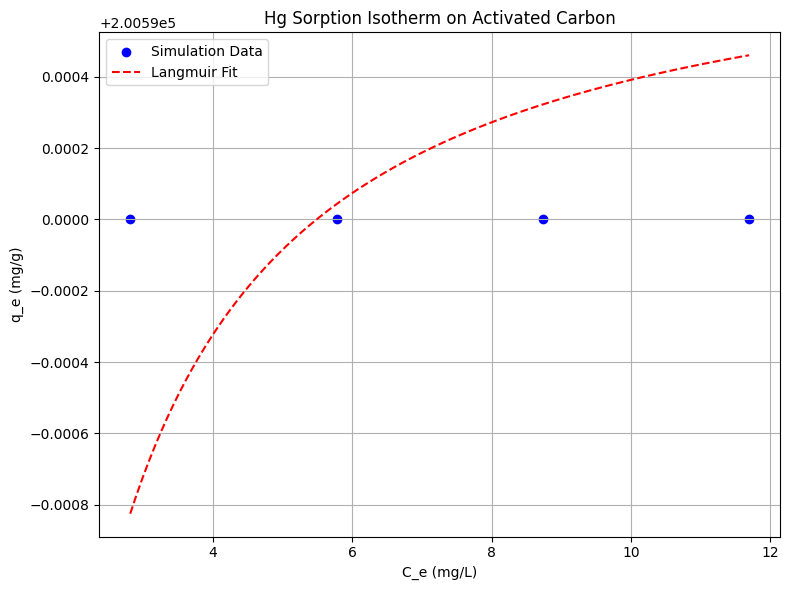

Langmuir fit parameters:
q_max= 200590.00 mg/g, K_L= 42151247.3148 L/mg


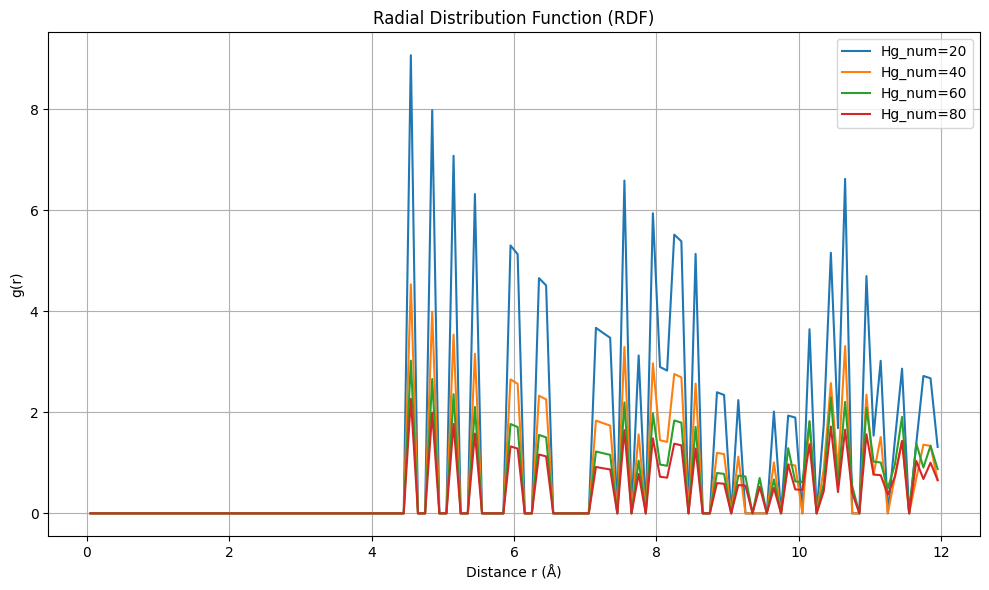

In [98]:
Hg_counts = [20, 40, 60, 80]
Ce_values = []
qe_values = []
rdf_data = []

for Hg_num in Hg_counts:
    setup_and_run_sim(Hg_num, functional_placement='edge')
    Ce, q_e, r, rdf, r_cut = analyze_simulation(Hg_num, box_dims=(150, 150, 100),
                                                initial_counts={'Hg': Hg_num, 'Mg': 10, 'Zn': 10, 'Ca': 10})
    if Ce is not None:
        Ce_values.append(Ce)
        qe_values.append(q_e)
        rdf_data.append((Hg_num, r, rdf))

# Save simulation data to CSV
with open('sorption_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(['Hg_num', 'Ce (mg/L)', 'q_e (mg/g)'])
    # Write data
    for Hg_num, Ce, q_e in zip(Hg_counts, Ce_values, qe_values):
        writer.writerow([Hg_num, Ce, q_e])

# Langmuir fit and plot
if len(Ce_values) > 2:
    def langmuir(C, q_max, K_L):
        return (q_max * K_L * C) / (1 + K_L * C)

    params, _ = curve_fit(langmuir, Ce_values, qe_values, p0=[max(qe_values), 0.1])
    Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
    qe_fit = langmuir(Ce_fit, *params)

    plt.figure(figsize=(8, 6))
    plt.scatter(Ce_values, qe_values, c='b', label='Simulation Data')
    plt.plot(Ce_fit, qe_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('C_e (mg/L)')
    plt.ylabel('q_e (mg/g)')
    plt.title('Hg Sorption Isotherm on Activated Carbon')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Langmuir fit parameters:")
    print(f"q_max= {params[0]:.2f} mg/g, K_L= {params[1]:.4f} L/mg")

# RDF plot
plt.figure(figsize=(10, 6))
for Hg_num, r, rdf in rdf_data:
    plt.plot(r, rdf, label=f'Hg_num={Hg_num}')
plt.xlabel('Distance r (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function (RDF)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [94]:
!pip install pymbar


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 5.1 MB/s eta 0:00:00


In [101]:
import os
import numpy as np
import subprocess
import pymbar
import matplotlib.pyplot as plt

def setup_umbrella_windows(
    base_data="data_umbrella.lmp",
    num_windows=10,
    z_min=2.0,
    z_max=15.0,
    k_spring=10.0,
    sim_steps=5000
):
    """
    Creates multiple subdirectories (window_00, window_01, etc.) each
    with a LAMMPS input script that restrains the Hg ion's z-position
    around z0 using fix spring/self. We rely on type=4 existing in base_data.
    """
    z_centers = np.linspace(z_min, z_max, num_windows)

    for i, z0 in enumerate(z_centers):
        wdir = f"window_{i:02d}"
        os.makedirs(wdir, exist_ok=True)

        # We do 'dump mydump all custom 100 rc_XX.txt'
        # so that the file is created in the local subdir (cwd = wdir).
        in_script = f"""
units           real
atom_style      full
boundary        p p p
read_data       {base_data}

pair_style      lj/cut/coul/long 12.0 12.0
kspace_style    pppm 1.0e-5

pair_coeff 1 1 0.07 3.40
pair_coeff 2 2 0.16 3.05
pair_coeff 3 3 0.02 0.00
pair_coeff 4 4 0.20 3.70
pair_coeff 5 5 0.10 3.40
pair_coeff 6 6 0.15 2.47
pair_coeff 7 7 0.20 2.90
pair_coeff 8 8 0.15 3.47
pair_modify mix arithmetic

bond_style      harmonic
bond_coeff      1 450.0 1.42
bond_coeff      2 450.0 0.9572
bond_coeff      3 450.0 1.43

angle_style     harmonic
angle_coeff     1 55.0 120.0
angle_coeff     2 55.0 104.52

neighbor        2.0 bin
neigh_modify    delay 0 every 1 check yes

group carbon type 1
fix fix_carbon carbon setforce 0.0 0.0 0.0

velocity        all create 300.0 12345 mom yes rot yes dist gaussian
fix             1 all shake 0.0001 20 0 a 1
fix             nvt_control all nvt temp 300.0 300.0 100.0

thermo          1000
thermo_style    custom step temp etotal press

# Dump every 100 steps, focusing on 'id type x y z'. The local file is rc_XX.txt
dump            mydump all custom 100 rc_{i:02d}.txt id type x y z

group myHg type 4
fix umbr myHg spring/self {k_spring} 0.0 0.0 {z0:.3f} 0 0 1

timestep        1.0
run             {sim_steps}
"""
        with open(os.path.join(wdir, f"in_umbrella_{i:02d}.lmp"), 'w') as fp:
            fp.write(in_script)


def run_umbrella_windows(num_windows=10):
    """
    Runs LAMMPS in each subdir window_XX, each containing in_umbrella_XX.lmp.
    We assume we truly have a type=4 (Hg) atom, so the dump files are produced.
    """
    lammps_bin = "/content/lammps/build/lmp"  # adapt if needed
    for i in range(num_windows):
        wdir = f"window_{i:02d}"
        in_file = f"in_umbrella_{i:02d}.lmp"
        if not os.path.exists(os.path.join(wdir, in_file)):
            raise RuntimeError(f"[ERROR] Missing LAMMPS input: {in_file} in {wdir}")
        print(f"Running umbrella window {i} in {wdir}")
        subprocess.run([lammps_bin, "-in", in_file], cwd=wdir, check=True)


def collect_umbrella_data(num_windows=10):
    """
    Reads the final 'rc_XX.txt' from each window_XX subdir,
    extracting the z(t) for type=4 (Hg).
    Returns a list z_data_list of length num_windows,
    where z_data_list[i] = np.array of z-values in window i.
    """
    z_data_list = []
    for i in range(num_windows):
        wdir = f"window_{i:02d}"
        dump_path = os.path.join(wdir, f"rc_{i:02d}.txt")
        if not os.path.isfile(dump_path):
            raise RuntimeError(f"[ERROR] Dump file {dump_path} not found! Check window_{i:02d} run.")

        # Parse lines for type=4
        raw_z = []
        with open(dump_path, 'r') as f:
            for line in f:
                if line.startswith("ITEM:"):
                    continue
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                a_type = int(parts[1])
                if a_type == 4:  # Hg
                    raw_z.append(float(parts[4]))

        if len(raw_z) == 0:
            raise RuntimeError(f"[ERROR] Dump {dump_path} has no type=4 lines. Possibly no Hg in this window?")

        z_data_list.append(np.array(raw_z))

    return z_data_list


def do_umbrella_mbar(z_data_list, z_centers, k_spring, T=300.0):
    """
    Use MBAR (pymbar) to unbias each umbrella window data.
     - z_data_list: list of arrays with z-values from each window
     - z_centers: list/array of center z0 for each window
     - k_spring: harmonic constant (kcal/mol/Å^2)
     - T: temperature in K
    Returns (bin_centers, pmf_kcal).
    """
    if len(z_data_list) == 0:
        raise ValueError("No umbrella data provided!")

    # Flatten all z-values
    all_z = []
    all_win = []
    for i, arr in enumerate(z_data_list):
        all_z.extend(arr)
        all_win.extend([i]*len(arr))

    all_z = np.array(all_z)
    all_win = np.array(all_win)

    # Calculate umbrella potential for each window
    kB_kcal = 0.0019872041  # kcal/(mol*K)
    beta = 1.0 / (kB_kcal * T)

    num_windows = len(z_centers)
    N_total = len(all_z)
    u_bias = np.zeros((num_windows, N_total), dtype=float)

    for i in range(num_windows):
        z0_i = z_centers[i]
        # U_i = 0.5 * k_spring * (z - z0_i)^2
        # dimensionless => multiply by beta
        u_bias[i, :] = 0.5 * k_spring * (all_z - z0_i)**2 * beta

    # Count samples from each window
    N_k = np.zeros(num_windows, dtype=int)
    for i in range(num_windows):
        N_k[i] = np.sum(all_win == i)

    # Now do MBAR
    mbar = pymbar.MBAR(u_bias, N_k, verbose=False)

    # We'll bin z to get a 1D PMF
    z_min = np.min(all_z)
    z_max = np.max(all_z)
    nbins = 100
    bin_edges = np.linspace(z_min, z_max, nbins+1)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

    # Assign each frame to a bin
    bin_index = np.digitize(all_z, bin_edges) - 1
    bin_index = np.clip(bin_index, 0, nbins-1)

    results = mbar.computePMF(u_bias, bin_index, nbins)
    f_i = results['f_i'] / beta  # from dimensionless to kcal/mol
    f_i -= np.min(f_i)          # shift zero to minimum

    return bin_centers, f_i


##############################################################################
# 6) Putting It All Together
##############################################################################
# A) Create a data file with 1 Hg for demonstration
create_data_file(num_Hg=1, filename="data_umbrella.lmp")

# B) Setup ~8 windows from z=2.0 to 15.0:
num_windows = 8
z_min, z_max = 2.0, 15.0
k_spring = 10.0  # kcal/mol/Å^2
setup_umbrella_windows(
    base_data="data_umbrella.lmp",
    num_windows=num_windows,
    z_min=z_min,
    z_max=z_max,
    k_spring=k_spring,
    sim_steps=5000  # short run, for demonstration
)

# C) Run each window
run_umbrella_windows(num_windows=num_windows)

# D) Collect z(t)
z_data_list = collect_umbrella_data(num_windows=num_windows)
z_centers = np.linspace(z_min, z_max, num_windows)

# E) Do MBAR-based analysis
bin_centers, pmf_kcal = do_umbrella_mbar(z_data_list, z_centers, k_spring, T=300.0)

# F) Plot PMF
plt.figure(figsize=(6,4))
plt.plot(bin_centers, pmf_kcal, 'bo-', label='PMF')
plt.xlabel('z (Å)')
plt.ylabel('Free Energy (kcal/mol)')
plt.title('1D PMF from Umbrella + MBAR')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

##############################################################################
# 7) Extract Delta G of Adsorption + Simple Isotherm
##############################################################################
# Let's assume the "adsorbed" region is near z ~ 2–4 Å,
# and the "bulk" region is z > ~12 Å, or wherever the PMF is plateaued.

bound_mask = (bin_centers >= 2.0) & (bin_centers <= 4.0)
bulk_mask  = (bin_centers >= 12.0) & (bin_centers <= 15.0)

if np.any(bound_mask) and np.any(bulk_mask):
    F_bound = np.min(pmf_kcal[bound_mask])
    F_bulk  = np.mean(pmf_kcal[bulk_mask])  # or np.min, or the plateau region
    deltaG_ads = F_bound - F_bulk  # negative => stable adsorption
    print(f"Estimated Delta G_ads = {deltaG_ads:.2f} kcal/mol")

    # Convert Delta G to K_ads:
    #   K = exp(-beta * DeltaG)
    #   with DeltaG in kcal/mol => beta = 1/(k_B T) in mol/kcal
    kB_kcal = 0.0019872041
    beta = 1.0/(kB_kcal*300.0)
    K_ads = np.exp(-beta * deltaG_ads)
    print(f"Adsorption equilibrium constant K_ads = {K_ads:.3g}")

    # Build a Langmuir-like isotherm:
    #   theta = K*C / (1 + K*C)
    #   We'll pick a range of concentrations from 1e-6 to 1e-1 M
    c_values = np.logspace(-6, -1, 50)  # in M
    theta_vals = K_ads*c_values/(1 + K_ads*c_values)
    # For a surface with N sites, or for 1 binding site, you might interpret q ~ theta

    plt.figure()
    plt.xscale('log')
    plt.plot(c_values, theta_vals, 'ro-')
    plt.xlabel('Metal Concentration (M)')
    plt.ylabel('Fraction Adsorbed (theta)')
    plt.title('Langmuir Isotherm from Umbrella Sampling')
    plt.grid(True)
    plt.show()

else:
    print("Could not identify bound/bulk regions in PMF—adjust your bin ranges.")

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



Created umbrella data file: data_umbrella.lmp with 29272 atoms.
Running umbrella window 0 in window_00


CalledProcessError: Command '['/content/lammps/build/lmp', '-in', 'in_umbrella_00.lmp']' returned non-zero exit status 1.